In [1]:
# Cell 1: Mount Google Drive and verify dataset structure
from google.colab import drive
import os
import random
import numpy as np
import torch
from pathlib import Path

# Mount Google Drive
print("📁 Mounting Google Drive...")
drive.mount('/content/drive')

# ========================================================================
# CORRECTED CONFIGURATION - Matches your desired structure
# ========================================================================
CONFIG = {
    # Data paths - Single folder structure (Training only)
    'image_dir': '/content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1-2_Training_Input',
    'mask_dir': '/content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1_Training_GroundTruth',

    # Training hyperparameters
    'batch_size': 12,
    'num_epochs': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'patience': 10,

    # Data splits (train/val/test from single training folder)
    'train_split': 0.8,   # 80% for training
    'val_split': 0.1,      # 10% for validation
    # Remaining 10% for test

    'num_workers': 4,
    'backbone': 'resnet50',
    'output_stride': 16,
    'save_dir': 'checkpoints_deeplabv3plus',
    'seed': 42
}

# ========================================================================
# Verify dataset structure
# ========================================================================
print("\n✅ Google Drive mounted successfully!")
print(f"\n📊 Checking dataset structure:\n")
print("="*60)

# Check if directories exist
if os.path.exists(CONFIG['image_dir']):
    image_count = len([f for f in os.listdir(CONFIG['image_dir'])
                      if f.endswith(('.jpg', '.png', '.jpeg'))])
    print(f"✅ Training Images: {image_count} files")
    print(f"   Path: {CONFIG['image_dir']}")
else:
    print(f"❌ Training Images: NOT FOUND")
    print(f"   Expected path: {CONFIG['image_dir']}")

print()

if os.path.exists(CONFIG['mask_dir']):
    mask_count = len([f for f in os.listdir(CONFIG['mask_dir'])
                     if f.endswith(('.png', '.jpg', '.jpeg'))])
    print(f"✅ Training Masks: {mask_count} files")
    print(f"   Path: {CONFIG['mask_dir']}")
else:
    print(f"❌ Training Masks: NOT FOUND")
    print(f"   Expected path: {CONFIG['mask_dir']}")

print("="*60)
print("\n📋 Data Split Configuration:")
print(f"   Training:   {CONFIG['train_split']*100:.0f}%")
print(f"   Validation: {CONFIG['val_split']*100:.0f}%")
print(f"   Test:       {(1-CONFIG['train_split']-CONFIG['val_split'])*100:.0f}%")
print("="*60)

# ========================================================================
# Cell 2: Helper function to prepare data splits
# ========================================================================
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def prepare_data_splits(image_dir, train_split=0.8, val_split=0.1, seed=42):
    """
    Split data into train/val/test sets from a single folder

    Args:
        image_dir: Path to image directory
        train_split: Proportion for training (default: 0.8)
        val_split: Proportion for validation (default: 0.1)
        seed: Random seed for reproducibility

    Returns:
        train_list, val_list, test_list: Lists of image filenames
    """
    set_seed(seed)

    # Get all image files
    image_files = sorted([f for f in os.listdir(image_dir)
                         if f.endswith(('.jpg', '.png', '.jpeg'))])

    total_images = len(image_files)

    # Calculate split indices
    train_size = int(total_images * train_split)
    val_size = int(total_images * val_split)

    # Shuffle and split
    random.shuffle(image_files)

    train_list = image_files[:train_size]
    val_list = image_files[train_size:train_size + val_size]
    test_list = image_files[train_size + val_size:]

    print(f"\n✅ Data split complete!")
    print(f"   Total images: {total_images}")
    print(f"   Training:     {len(train_list)} ({len(train_list)/total_images*100:.1f}%)")
    print(f"   Validation:   {len(val_list)} ({len(val_list)/total_images*100:.1f}%)")
    print(f"   Test:         {len(test_list)} ({len(test_list)/total_images*100:.1f}%)")

    return train_list, val_list, test_list

# ========================================================================
# Cell 3: Execute data preparation
# ========================================================================
set_seed(CONFIG['seed'])

print("\n[STEP 1/7] Preparing data splits...")
train_list, val_list, test_list = prepare_data_splits(
    CONFIG['image_dir'],
    train_split=CONFIG['train_split'],
    val_split=CONFIG['val_split'],
    seed=CONFIG['seed']
)

print("\n" + "="*60)
print("Dataset verification and split complete!")
print("="*60)
print("\n✅ Ready to create datasets and dataloaders")
print(f"   Use CONFIG dictionary for model training")
print(f"   Image directory: {CONFIG['image_dir']}")
print(f"   Mask directory:  {CONFIG['mask_dir']}")

📁 Mounting Google Drive...
Mounted at /content/drive

✅ Google Drive mounted successfully!

📊 Checking dataset structure:

✅ Training Images: 2594 files
   Path: /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1-2_Training_Input

✅ Training Masks: 2594 files
   Path: /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1_Training_GroundTruth

📋 Data Split Configuration:
   Training:   80%
   Validation: 10%
   Test:       10%

[STEP 1/7] Preparing data splits...

✅ Data split complete!
   Total images: 2594
   Training:     2075 (80.0%)
   Validation:   259 (10.0%)
   Test:         260 (10.0%)

Dataset verification and split complete!

✅ Ready to create datasets and dataloaders
   Use CONFIG dictionary for model training
   Image directory: /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1-2_Training_Input
   Mask directory:  /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1_Training_GroundTruth


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cell 2: Install necessary libraries
print("📦 Installing required libraries...")
print("This will take 1-2 minutes\n")

# Install segmentation models and augmentation library
!pip install -q segmentation-models-pytorch albumentations

print("\n✅ Installation complete!")

# Verify installations
import torch
import segmentation_models_pytorch as smp
import albumentations as A

print(f"\n📊 Environment Details:")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"   SMP version: {smp.__version__}")

📦 Installing required libraries...
This will take 1-2 minutes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.5 MB/s eta 0:00:00

✅ Installation complete!

📊 Environment Details:
   PyTorch version: 2.9.0+cu126
   CUDA available: True
   GPU: NVIDIA A100-SXM4-80GB
   GPU Memory: 85.17 GB
   SMP version: 0.5.0


In [4]:
# Cell 3: Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation models
import segmentation_models_pytorch as smp

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ All libraries imported successfully!")
print(f"🎯 Using device: {device}")
print(f"🌱 Random seed set to: 42")


✅ All libraries imported successfully!
🎯 Using device: cuda
🌱 Random seed set to: 42


📝 Logging output to: exploration_output/exploration_log_20251207_111644.txt
🖼️  Saving images to: exploration_output/

DATA EXPLORATION & VISUALIZATION
📂 Image directory: /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1-2_Training_Input
📂 Mask directory:  /content/drive/MyDrive/CMPE255/Project/ISIC2018_Task1_Training_GroundTruth

📊 Total training images: 2594

🖼️  VISUALIZING RANDOM SAMPLES FROM TRAINING SET:

Sample 1: ISIC_0000555.jpg
  ├─ Image size: (680, 833, 3)
  ├─ Mask size:  (680, 833)
  ├─ Lesion area: 19.46%
  └─ Pixel range: [0, 233]

Sample 2: ISIC_0000112.jpg
  ├─ Image size: (1536, 2048, 3)
  ├─ Mask size:  (1536, 2048)
  ├─ Lesion area: 20.27%
  └─ Pixel range: [0, 226]

Sample 3: ISIC_0011333.jpg
  ├─ Image size: (768, 1024, 3)
  ├─ Mask size:  (768, 1024)
  ├─ Lesion area: 34.59%
  └─ Pixel range: [17, 255]

Sample 4: ISIC_0010850.jpg
  ├─ Image size: (768, 1024, 3)
  ├─ Mask size:  (768, 1024)
  ├─ Lesion area: 13.63%
  └─ Pixel range: [0, 254]

💾 Saved visualiz

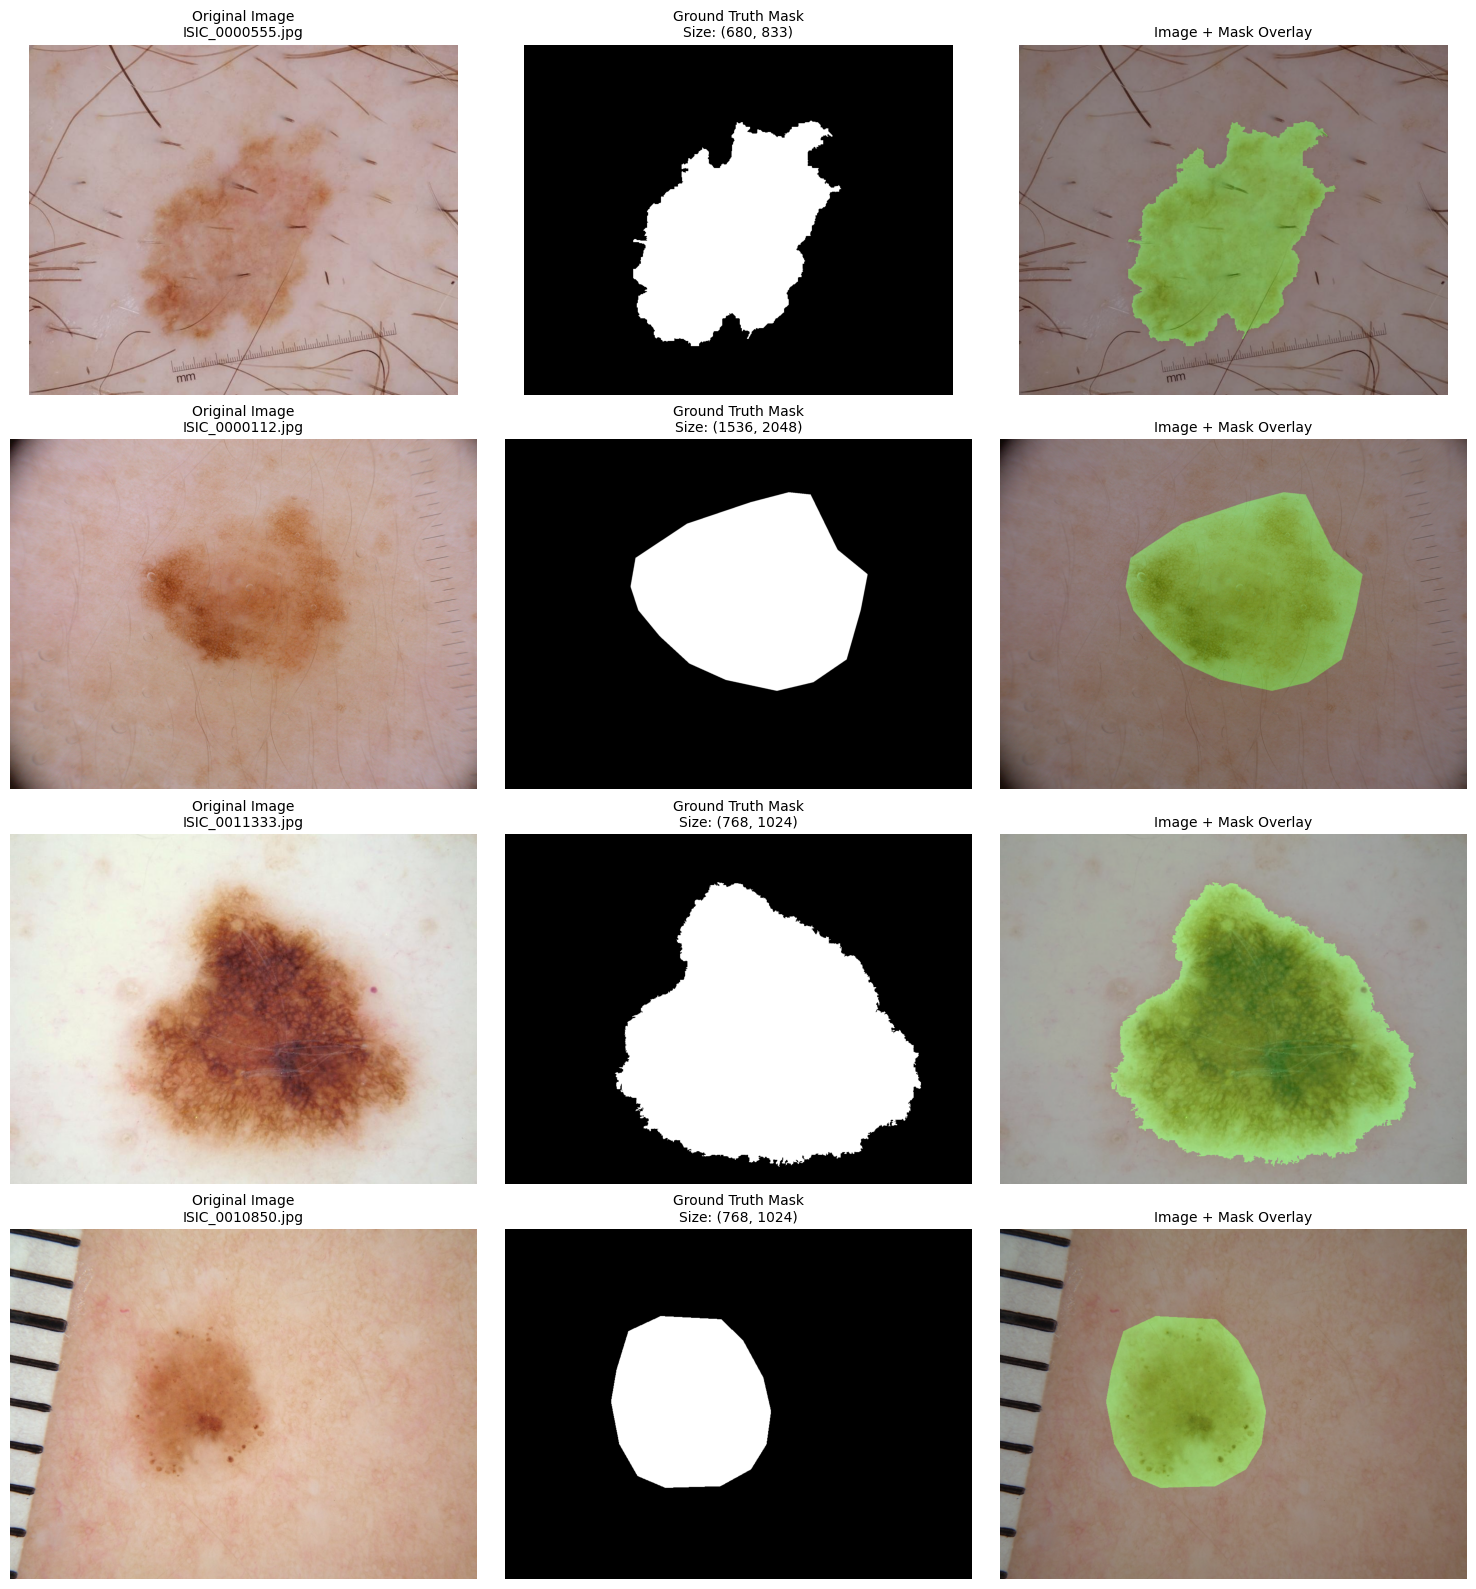


📈 DATASET STATISTICS

Calculating statistics...

✅ Statistics from 2594 samples:
   ├─ Mean lesion area: 21.40%
   ├─ Std lesion area:  20.83%
   ├─ Min lesion area:  0.30%
   ├─ Max lesion area:  98.66%
   └─ Median lesion area: 13.81%

📐 Image dimensions found: 206 unique size(s)
   └─ (566, 679): 1 images (0.0%)
   └─ (4420, 6640): 3 images (0.1%)
   └─ (4441, 6681): 3 images (0.1%)
   └─ (4439, 6748): 1 images (0.0%)
   └─ (4422, 6622): 1 images (0.0%)

💾 Saved statistics plot: exploration_output/statistics_20251207_111644.png


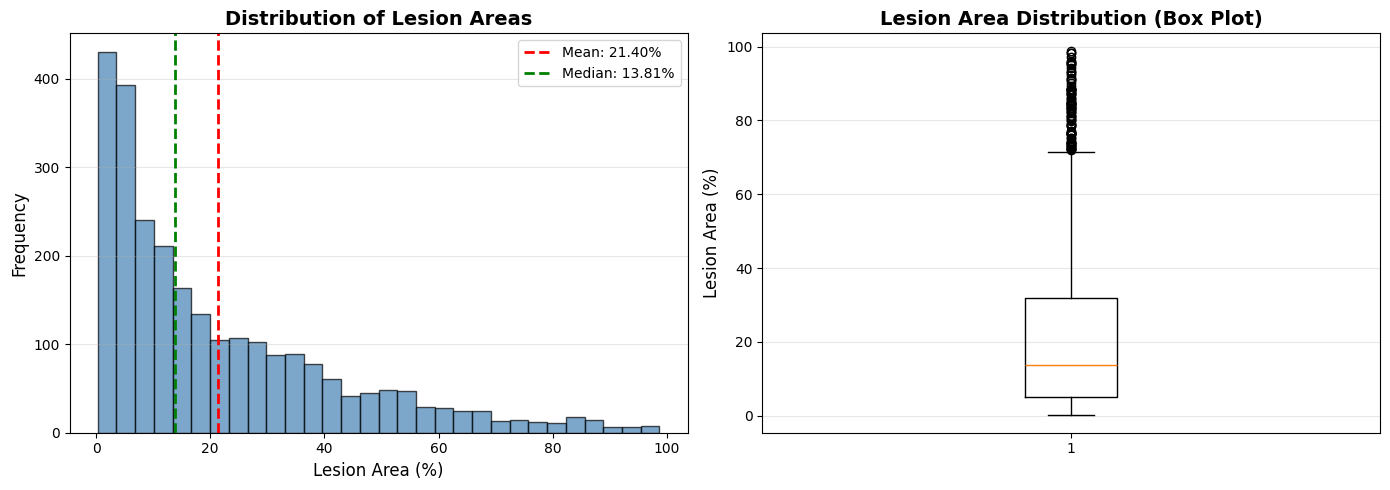


✅ Data exploration complete!
📁 All outputs saved to: exploration_output/

✅ Log file saved: exploration_output/exploration_log_20251207_111644.txt


In [5]:
# Cell 4: Data Exploration - Visualize samples (WITH OUTPUT SAVING)
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from datetime import datetime
import sys

# ========================================================================
# Setup output saving
# ========================================================================
# Create output directory
output_dir = "exploration_output"
os.makedirs(output_dir, exist_ok=True)

# Create timestamped log file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(output_dir, f"exploration_log_{timestamp}.txt")

# Custom print function that writes to both console and file
class Logger:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, "w", encoding="utf-8")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

    def close(self):
        self.log.close()

# Initialize logger
logger = Logger(log_file)
sys.stdout = logger

print(f"📝 Logging output to: {log_file}")
print(f"🖼️  Saving images to: {output_dir}/")
print()

# ========================================================================
# Use CONFIG from previous cell
# ========================================================================
# Dataset paths - using the corrected structure
train_img_dir = CONFIG['image_dir']
train_mask_dir = CONFIG['mask_dir']

print("="*60)
print("DATA EXPLORATION & VISUALIZATION")
print("="*60)
print(f"📂 Image directory: {train_img_dir}")
print(f"📂 Mask directory:  {train_mask_dir}")
print()

# Get list of image files
image_files = sorted([f for f in os.listdir(train_img_dir)
                     if f.endswith(('.jpg', '.png', '.jpeg'))])
print(f"📊 Total training images: {len(image_files)}")
print("="*60)

# ========================================================================
# Function to display image and mask
# ========================================================================
def show_samples(num_samples=4, image_list=None, seed=None, save_prefix="samples"):
    """
    Display random samples with original image, mask, and overlay

    Args:
        num_samples: Number of samples to display
        image_list: Optional list of specific images to show (uses train_list by default)
        seed: Random seed for reproducibility
        save_prefix: Prefix for saved image filename
    """
    if seed is not None:
        random.seed(seed)

    # Use provided image list or all images
    if image_list is None:
        available_images = image_files
    else:
        available_images = image_list

    # Ensure we don't try to sample more than available
    num_samples = min(num_samples, len(available_images))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*4))

    # Handle single sample case (axes won't be 2D)
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # Select random samples
    sample_images = random.sample(available_images, num_samples)

    for idx, img_name in enumerate(sample_images):
        # Load image
        img_path = os.path.join(train_img_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"⚠️  Warning: Could not load image {img_name}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (mask name format: ISIC_XXXXXXX_segmentation.png)
        # Handle different possible naming conventions
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(train_mask_dir, mask_name)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"⚠️  Warning: Could not load mask {mask_name}")
            continue

        # Display original image
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f'Original Image\n{img_name}', fontsize=10)
        axes[idx, 0].axis('off')

        # Display mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title(f'Ground Truth Mask\nSize: {mask.shape}', fontsize=10)
        axes[idx, 1].axis('off')

        # Display overlay
        overlay = image.copy()
        mask_colored = np.zeros_like(image)
        mask_colored[:, :, 1] = mask  # Green channel for lesion
        overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)

        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title('Image + Mask Overlay', fontsize=10)
        axes[idx, 2].axis('off')

        # Print statistics
        lesion_area = (mask > 127).sum() / mask.size * 100
        print(f"Sample {idx+1}: {img_name}")
        print(f"  ├─ Image size: {image.shape}")
        print(f"  ├─ Mask size:  {mask.shape}")
        print(f"  ├─ Lesion area: {lesion_area:.2f}%")
        print(f"  └─ Pixel range: [{image.min()}, {image.max()}]")
        print()

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(output_dir, f"{save_prefix}_{timestamp}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Saved visualization: {save_path}")

    plt.show()

# ========================================================================
# Display samples from different splits
# ========================================================================
print("\n🖼️  VISUALIZING RANDOM SAMPLES FROM TRAINING SET:\n")
show_samples(num_samples=4, seed=CONFIG['seed'], save_prefix="training_samples")

# ========================================================================
# Optional: Display samples from each split
# ========================================================================
def show_split_samples(train_list, val_list, test_list, samples_per_split=2):
    """
    Show samples from each data split (train/val/test)
    """
    print("\n" + "="*60)
    print("📊 SAMPLES FROM EACH DATA SPLIT")
    print("="*60)

    # Training samples
    print(f"\n🔵 TRAINING SET ({len(train_list)} images):")
    print("-"*60)
    show_samples(num_samples=samples_per_split, image_list=train_list,
                seed=CONFIG['seed'], save_prefix="split_training")

    # Validation samples
    print(f"\n🟢 VALIDATION SET ({len(val_list)} images):")
    print("-"*60)
    show_samples(num_samples=samples_per_split, image_list=val_list,
                seed=CONFIG['seed']+1, save_prefix="split_validation")

    # Test samples
    print(f"\n🟡 TEST SET ({len(test_list)} images):")
    print("-"*60)
    show_samples(num_samples=samples_per_split, image_list=test_list,
                seed=CONFIG['seed']+2, save_prefix="split_test")

# Uncomment to show samples from each split
# show_split_samples(train_list, val_list, test_list, samples_per_split=2)

# ========================================================================
# Dataset Statistics
# ========================================================================
print("\n" + "="*60)
print("📈 DATASET STATISTICS")
print("="*60)

# Calculate statistics across all images
print("\nCalculating statistics...")
sample_size = len(image_files)
sampled_images = random.sample(image_files, sample_size)

lesion_areas = []
image_sizes = []

for img_name in sampled_images:
    # Load mask
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"{base_name}_segmentation.png"
    mask_path = os.path.join(train_mask_dir, mask_name)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        lesion_area = (mask > 127).sum() / mask.size * 100
        lesion_areas.append(lesion_area)
        image_sizes.append(mask.shape)

if lesion_areas:
    print(f"\n✅ Statistics from {len(lesion_areas)} samples:")
    print(f"   ├─ Mean lesion area: {np.mean(lesion_areas):.2f}%")
    print(f"   ├─ Std lesion area:  {np.std(lesion_areas):.2f}%")
    print(f"   ├─ Min lesion area:  {np.min(lesion_areas):.2f}%")
    print(f"   ├─ Max lesion area:  {np.max(lesion_areas):.2f}%")
    print(f"   └─ Median lesion area: {np.median(lesion_areas):.2f}%")

    # Most common image size
    unique_sizes = list(set(image_sizes))
    print(f"\n📐 Image dimensions found: {len(unique_sizes)} unique size(s)")
    for size in unique_sizes[:5]:  # Show first 5
        count = image_sizes.count(size)
        print(f"   └─ {size}: {count} images ({count/len(image_sizes)*100:.1f}%)")

    # Create statistics visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram of lesion areas
    axes[0].hist(lesion_areas, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(lesion_areas), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(lesion_areas):.2f}%')
    axes[0].axvline(np.median(lesion_areas), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {np.median(lesion_areas):.2f}%')
    axes[0].set_xlabel('Lesion Area (%)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Lesion Areas', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Box plot of lesion areas
    axes[1].boxplot(lesion_areas, vert=True)
    axes[1].set_ylabel('Lesion Area (%)', fontsize=12)
    axes[1].set_title('Lesion Area Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    # Save statistics plot
    stats_path = os.path.join(output_dir, f"statistics_{timestamp}.png")
    plt.savefig(stats_path, dpi=150, bbox_inches='tight')
    print(f"\n💾 Saved statistics plot: {stats_path}")

    plt.show()

print("\n" + "="*60)
print("✅ Data exploration complete!")
print(f"📁 All outputs saved to: {output_dir}/")
print("="*60)

# Close logger
sys.stdout = logger.terminal
logger.close()
print(f"\n✅ Log file saved: {log_file}")